In [1]:
import itertools
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


In [7]:
#!nvidia-smi

In [3]:
FILE = "XCAT-ERIC/results/simulation_results_20260109T221333.mat"  

def h5_tree(file_path, max_items=250):
    items = []
    with h5py.File(file_path, "r") as f:
        def visit(name, obj):
            if isinstance(obj, h5py.Dataset):
                items.append(("D", name, obj.shape, str(obj.dtype)))
            else:
                items.append(("G", name, None, None))
        f.visititems(visit)
    for t, name, shape, dtype in items[:max_items]:
        if t == "D":
            print(f"DATASET  {name:50s}  shape={shape}  dtype={dtype}")
        else:
            print(f"GROUP    {name}")
    if len(items) > max_items:
        print(f"... ({len(items)-max_items} more)")

h5_tree(FILE)


GROUP    #refs#
DATASET  #refs#/a                                            shape=(2,)  dtype=uint64
GROUP    results
GROUP    results/images
GROUP    results/images/GroundTruth
DATASET  results/images/GroundTruth/img                      shape=(181, 6, 220, 152)  dtype=float32
DATASET  results/images/GroundTruth/timing                   shape=(181, 1)  dtype=float64
GROUP    results/images/Recon
DATASET  results/images/Recon/img                            shape=(60, 6, 220, 152)  dtype=float64
DATASET  results/images/Recon/timing                         shape=(60, 1)  dtype=float64
GROUP    results/kspace
DATASET  results/kspace/DCE                                  shape=(60, 8, 588, 220)  dtype=[('real', '<f8'), ('imag', '<f8')]
GROUP    results/kspace/meta
DATASET  results/kspace/meta/TR_ms                           shape=(1, 1)  dtype=float64
DATASET  results/kspace/meta/isCartesian                     shape=(1, 1)  dtype=float64
DATASET  results/kspace/meta/matrixAP              

In [4]:
PATH_K_DCE   = "/results/kspace/DCE"            
PATH_TRAJ    = "/results/kspace/trajDCE"        
PATH_GT_IMG  = "/results/images/GroundTruth/img"
PATH_RC_IMG  = "/results/images/Recon/img"
PATH_GT_TIM  = "/results/images/GroundTruth/timing"   
PATH_RC_TIM  = "/results/images/Recon/timing"         


In [5]:
def _as_complex(arr: np.ndarray) -> np.ndarray:
    if arr.dtype.fields and ("real" in arr.dtype.fields) and ("imag" in arr.dtype.fields):
        return arr["real"] + 1j * arr["imag"]
    return arr

def h5_load(file_path: str, path_in_file: str) -> np.ndarray:
    with h5py.File(file_path, "r") as f:
        arr = f[path_in_file][()]
    return _as_complex(arr)

def h5_exists(file_path: str, path_in_file: str) -> bool:
    with h5py.File(file_path, "r") as f:
        return path_in_file in f


In [6]:
k_raw  = h5_load(FILE, PATH_K_DCE)
tr_raw = h5_load(FILE, PATH_TRAJ)

def canonicalize_k_and_traj(k, traj, coil_max=64):
    best = None
    for p_tr in itertools.permutations(range(4)):
        trp = np.transpose(traj, p_tr)
        if trp.shape[2] != 3:
            continue
        ROc, Spc, _, Fc = trp.shape
        for p_k in itertools.permutations(range(4)):
            kp = np.transpose(k, p_k)
            if kp.shape[0] == ROc and kp.shape[1] == Spc and kp.shape[3] == Fc:
                coils = kp.shape[2]
                if coils <= coil_max:
                    cand = (coils, p_tr, p_k, trp, kp)
                    if best is None:
                        best = cand
    if best is None:
        raise RuntimeError(f"Could not find consistent permutations. k={k.shape}, traj={traj.shape}")
    _, p_tr, p_k, trp, kp = best
    return kp, trp

k_dce, traj = canonicalize_k_and_traj(k_raw, tr_raw)
k_dce = k_dce.astype(np.complex64, copy=False)
traj  = traj.astype(np.float32, copy=False)

RO, S, C, T = k_dce.shape
print("k_dce:", k_dce.shape, "traj:", traj.shape, "complex?", np.iscomplexobj(k_dce))


k_dce: (60, 588, 8, 220) traj: (60, 588, 3, 220) complex? True


In [7]:
gt_img = h5_load(FILE, PATH_GT_IMG).astype(np.float32)
rc_img = h5_load(FILE, PATH_RC_IMG).astype(np.float32)
gt_tim = h5_load(FILE, PATH_GT_TIM).reshape(-1) if h5_exists(FILE, PATH_GT_TIM) else None
rc_tim = h5_load(FILE, PATH_RC_TIM).reshape(-1) if h5_exists(FILE, PATH_RC_TIM) else None

print("gt_img:", gt_img.shape, "rc_img:", rc_img.shape)


gt_img: (181, 6, 220, 152) rc_img: (60, 6, 220, 152)


gt_img_raw: (181, 6, 220, 152)
rc_img_raw: (60, 6, 220, 152)


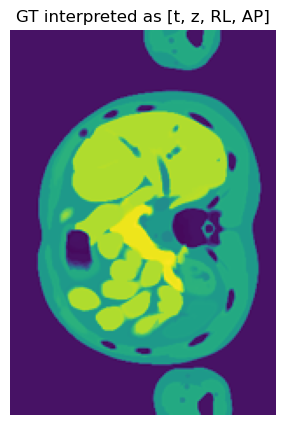

In [8]:
print("gt_img_raw:", gt_img.shape)
print("rc_img_raw:", rc_img.shape)

t = 0
z = 0
plt.figure(figsize=(5,5))
plt.imshow(gt_img[t, z, :, :], aspect="equal")
plt.title("GT interpreted as [t, z, RL, AP]")
plt.axis("off")
plt.show()


In [9]:

gt_img = np.transpose(gt_img, (2, 3, 1, 0))
rc_img = np.transpose(rc_img, (2, 3, 1, 0))

print("gt_img:", gt_img.shape)  
print("rc_img:", rc_img.shape)  



gt_img: (220, 152, 6, 181)
rc_img: (220, 152, 6, 60)


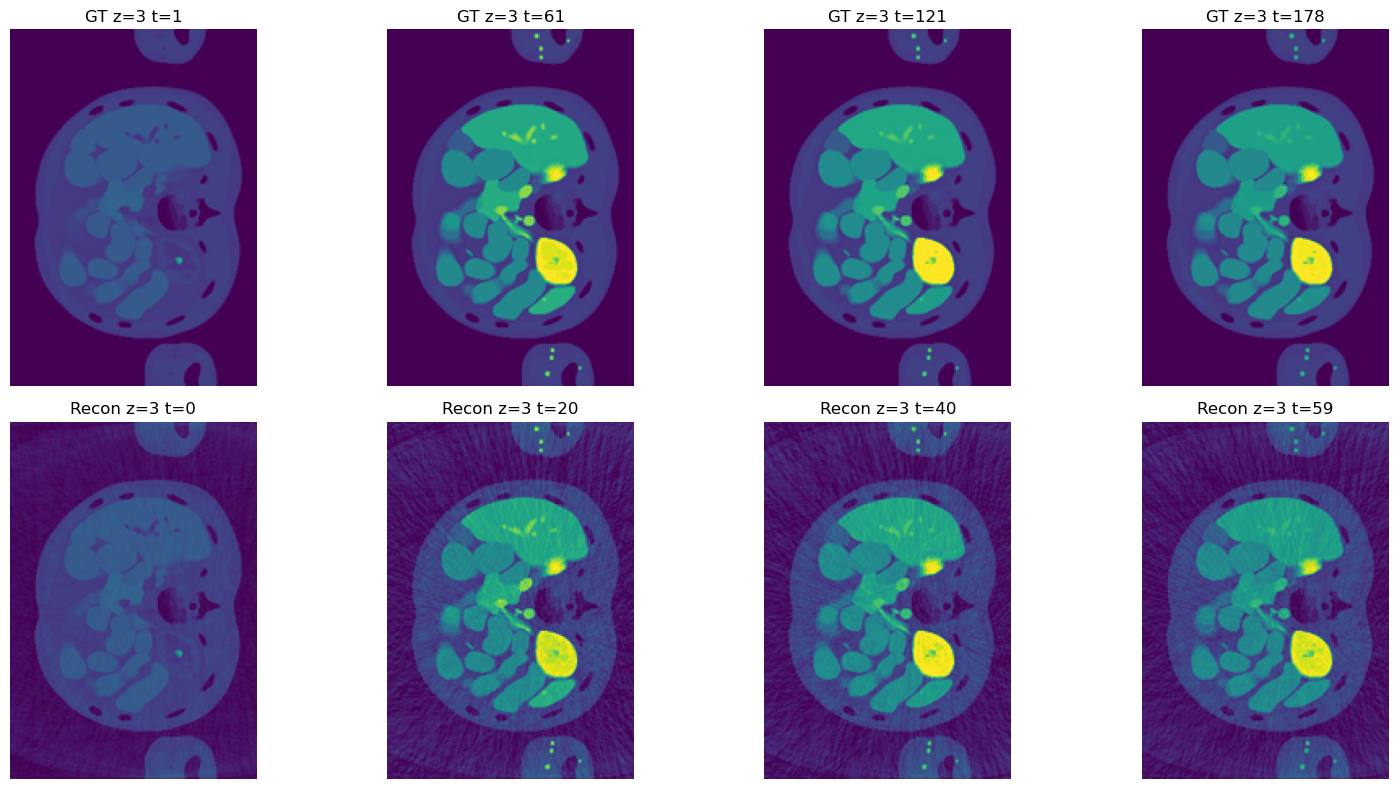

In [10]:
def pick_times(T, n=4):
    if T <= n:
        return list(range(T))
    return [0, T//3, 2*T//3, T-1]

z_idx = gt_img.shape[2] // 2
t_rc_list = pick_times(rc_img.shape[3], 4)

if gt_tim is not None and rc_tim is not None and len(gt_tim) == gt_img.shape[3] and len(rc_tim) == rc_img.shape[3]:
    t_gt_list = [int(np.argmin(np.abs(gt_tim - rc_tim[t]))) for t in t_rc_list]
else:
    t_gt_list = [int(round(t * (gt_img.shape[3]-1) / max(1, rc_img.shape[3]-1))) for t in t_rc_list]

vmax = float(np.percentile(gt_img, 99))

fig, axes = plt.subplots(2, len(t_rc_list), figsize=(4*len(t_rc_list), 8))
for i, (tg, tr) in enumerate(zip(t_gt_list, t_rc_list)):
    axes[0,i].imshow(gt_img[:,:,z_idx,tg], vmin=0, vmax=vmax, aspect="equal")
    axes[0,i].set_title(f"GT z={z_idx} t={tg}")
    axes[0,i].axis("off")

    axes[1,i].imshow(rc_img[:,:,z_idx,tr], vmin=0, vmax=vmax, aspect="equal")
    axes[1,i].set_title(f"Recon z={z_idx} t={tr}")
    axes[1,i].axis("off")
plt.tight_layout()
plt.show()




In [11]:
print("k_dce:", k_dce.shape, k_dce.dtype)

print("traj:", traj.shape, traj.dtype)

T, S, C, RO = k_dce.shape

if traj.shape == (T, S, RO, 3):
    TRAJ_MODE = "TSRO3"
elif traj.shape == (T, S, 3, RO):
    TRAJ_MODE = "TS3RO"
else:
    raise ValueError(f"Unexpected traj shape. Expected {(T,S,RO,3)} or {(T,S,3,RO)} but got {traj.shape}")

print("TRAJ_MODE:", TRAJ_MODE)


k_dce: (60, 588, 8, 220) complex64
traj: (60, 588, 3, 220) float32
TRAJ_MODE: TS3RO


In [12]:

def get_kxyz(traj, t, s, mode):
    if mode == "TSRO3":
        kx = traj[t, s, :, 0]
        ky = traj[t, s, :, 1]
        kz = traj[t, s, :, 2]
    else:  
        kx = traj[t, s, 0, :]
        ky = traj[t, s, 1, :]
        kz = traj[t, s, 2, :]
    return kx, ky, kz


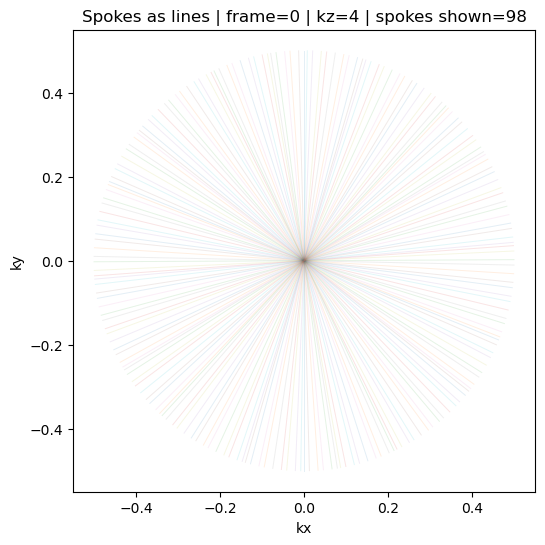

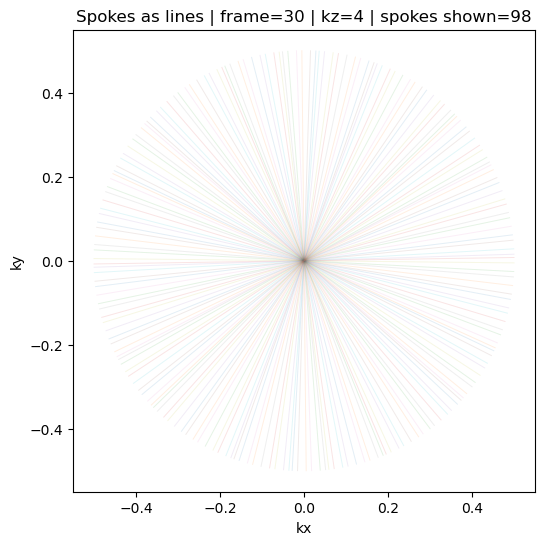

In [13]:
def plot_spokes_lines(traj, t=0, mode="TSRO3", kz_target=None, n_spokes=120, alpha=0.12, lw=0.7):
    T, S = traj.shape[0], traj.shape[1]

    if mode == "TSRO3":
        kz_sp = traj[t, :, 0, 2]   # (S,)
    else:
        kz_sp = traj[t, :, 2, 0]   # (S,)

    if kz_target is None:
        kz_bins = np.sort(np.unique(kz_sp))
        kz_target = float(kz_bins[len(kz_bins)//2])

    sp_idx = np.where(np.isclose(kz_sp, kz_target))[0]
    if len(sp_idx) == 0:
        raise ValueError("No spokes found for kz_target")

    if len(sp_idx) > n_spokes:
        sp_idx = sp_idx[np.linspace(0, len(sp_idx)-1, n_spokes).astype(int)]

    plt.figure(figsize=(6,6))
    for s in sp_idx:
        kx, ky, kz = get_kxyz(traj, t, s, mode)
        plt.plot(kx, ky, alpha=alpha, lw=lw)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Spokes as lines | frame={t} | kz={kz_target:.4g} | spokes shown={len(sp_idx)}")
    plt.xlabel("kx"); plt.ylabel("ky")
    plt.show()

plot_spokes_lines(traj, t=0, mode=TRAJ_MODE)
plot_spokes_lines(traj, t=T//2, mode=TRAJ_MODE)


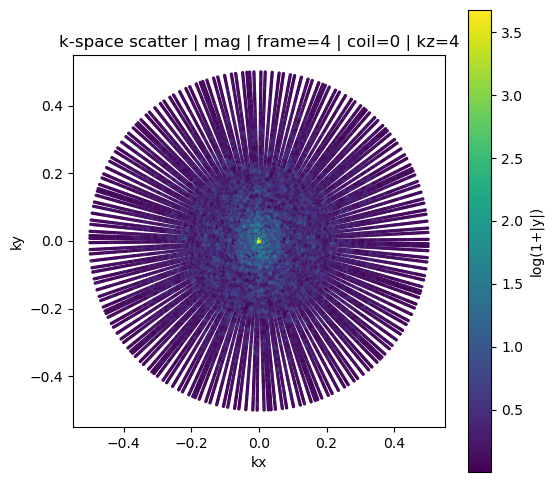

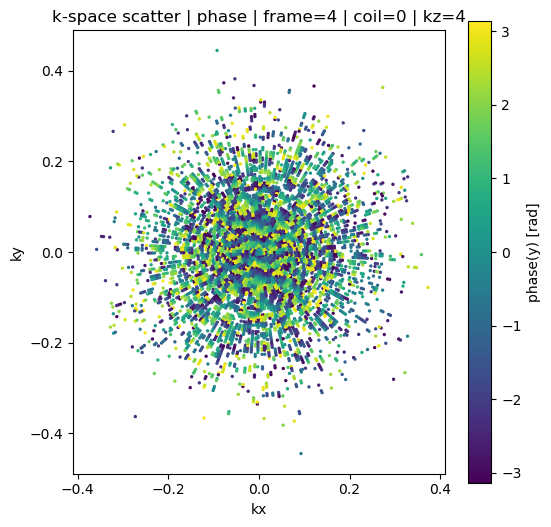

In [14]:
def plot_kspace_scatter(k_dce, traj, t=0, coil=0, mode="mag", kz_target=None,
                        max_points=400_000, s=2, mode_traj="TSRO3"):
    T, S, C, RO = k_dce.shape

    if mode_traj == "TSRO3":
        kz_sp = traj[t, :, 0, 2]
    else:
        kz_sp = traj[t, :, 2, 0]

    if kz_target is None:
        kz_bins = np.sort(np.unique(kz_sp))
        kz_target = float(kz_bins[len(kz_bins)//2])

    sp_idx = np.where(np.isclose(kz_sp, kz_target))[0]
    if len(sp_idx) == 0:
        raise ValueError("No spokes for kz_target")

    kx_list, ky_list, y_list = [], [], []
    for sidx in sp_idx:
        kx, ky, _ = get_kxyz(traj, t, sidx, mode_traj)
        y = k_dce[t, sidx, coil, :]  # (RO,)
        kx_list.append(kx); ky_list.append(ky); y_list.append(y)

    kx = np.concatenate(kx_list)
    ky = np.concatenate(ky_list)
    y  = np.concatenate(y_list)

    N = kx.size
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)
        kx, ky, y = kx[idx], ky[idx], y[idx]

    if mode == "mag":
        c = np.log1p(np.abs(y)); clabel = "log(1+|y|)"
    elif mode == "phase":
        mag = np.abs(y)
        keep = mag >= np.percentile(mag, 60)
        kx, ky, y = kx[keep], ky[keep], y[keep]
        c = np.angle(y); clabel = "phase(y) [rad]"
    else:
        raise ValueError("mode must be mag or phase")

    plt.figure(figsize=(6,6))
    sc = plt.scatter(kx, ky, c=c, s=s)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"k-space scatter | {mode} | frame={t} | coil={coil} | kz={kz_target:.4g}")
    plt.xlabel("kx"); plt.ylabel("ky")
    plt.colorbar(sc, label=clabel)
    plt.show()

# Example frames
plot_kspace_scatter(k_dce, traj, t=4, coil=0, mode="mag", mode_traj=TRAJ_MODE)
plot_kspace_scatter(k_dce, traj, t=4, coil=0, mode="phase", mode_traj=TRAJ_MODE)




In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# coordinate scaling to ~[-1,1] (important)
coords = traj.reshape(-1, 3, RO)  # not used directly; just for scale estimate
# Use a robust scale estimate from all points but only one RO sample per point to reduce compute:
kx_all = traj[:, :, 0, :].reshape(-1)
ky_all = traj[:, :, 1, :].reshape(-1)
kz_all = traj[:, :, 2, :].reshape(-1)
sx = float(np.max(np.abs(kx_all)) + 1e-8)
sy = float(np.max(np.abs(ky_all)) + 1e-8)
sz = float(np.max(np.abs(kz_all)) + 1e-8)

class FourierFeatures(nn.Module):
    def __init__(self, in_dim, n_freq=64, sigma=6.0):
        super().__init__()
        B = torch.randn(in_dim, n_freq) * sigma
        self.register_buffer("B", B)

    def forward(self, x):
        proj = 2.0 * np.pi * (x @ self.B)
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, w0=30.0, is_first=False):
        super().__init__()
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features)
        self.w0 = w0
        self.is_first = is_first
        self._init_weights()

    def _init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                bound = np.sqrt(6 / self.in_features) / self.w0
                self.linear.weight.uniform_(-bound, bound)

    def forward(self, x):
        return torch.sin(self.w0 * self.linear(x))

class NIK_SIREN(nn.Module):
    def __init__(self, n_coils, k_freq=96, t_freq=16, k_sigma=6.0, t_sigma=3.0,
                 coil_emb=16, hidden=256, depth=7, w0=30.0):
        super().__init__()
        self.ff_k = FourierFeatures(3, n_freq=k_freq, sigma=k_sigma)
        self.ff_t = FourierFeatures(1, n_freq=t_freq, sigma=t_sigma)
        self.coil_emb = nn.Embedding(n_coils, coil_emb)

        in_dim = 2*k_freq + 2*t_freq + coil_emb
        layers = [SineLayer(in_dim, hidden, w0=w0, is_first=True)]
        for _ in range(depth-2):
            layers.append(SineLayer(hidden, hidden, w0=w0, is_first=False))
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(hidden, 2)  # [log_mag, phase_raw]

    def forward(self, kxyz_t, coil_idx):
        # kxyz_t: (B,4) = [kx,ky,kz,t_norm]
        k = kxyz_t[:, :3]
        t = kxyz_t[:, 3:4]
        zk = self.ff_k(k)
        zt = self.ff_t(t)
        ec = self.coil_emb(coil_idx)
        h = torch.cat([zk, zt, ec], dim=-1)
        h = self.backbone(h)
        out = self.head(h)
        log_mag = out[:, 0:1]
        phase = np.pi * torch.tanh(out[:, 1:2])  # bounded
        return log_mag, phase

def magphase_to_ri(log_mag, phase):
    mag = torch.exp(log_mag)
    re = mag * torch.cos(phase)
    im = mag * torch.sin(phase)
    return torch.cat([re, im], dim=1)  # (B,2)




In [16]:
def sample_batch(batch_size):
    # random measured indices
    t = np.random.randint(0, T, size=batch_size)
    s = np.random.randint(0, S, size=batch_size)
    c = np.random.randint(0, C, size=batch_size)
    ro = np.random.randint(0, RO, size=batch_size)

    # coords
    kx = traj[t, s, 0, ro] / sx
    ky = traj[t, s, 1, ro] / sy
    kz = traj[t, s, 2, ro] / sz
    t_norm = (t.astype(np.float32) / (T - 1 + 1e-8)) * 2.0 - 1.0  # [-1,1]

    x = np.stack([kx, ky, kz, t_norm], axis=1).astype(np.float32)  # (B,4)

    y = k_dce[t, s, c, ro]
    y_ri = np.stack([y.real, y.imag], axis=1).astype(np.float32)   # (B,2)

    return (torch.from_numpy(x).to(device),
            torch.from_numpy(c.astype(np.int64)).to(device),
            torch.from_numpy(y_ri).to(device))




In [17]:
class PlateauStopper:
    def __init__(self, window=50, min_rel_improve=5e-4, patience=8):
        self.window = window
        self.min_rel_improve = min_rel_improve
        self.patience = patience
        self.hist = []
        self.bad = 0

    def step(self, loss):
        self.hist.append(loss)
        if len(self.hist) < 2*self.window:
            return False
        a = np.mean(self.hist[-2*self.window:-self.window])
        b = np.mean(self.hist[-self.window:])
        rel = (a - b) / max(a, 1e-12)
        if rel < self.min_rel_improve:
            self.bad += 1
        else:
            self.bad = 0
        return self.bad >= self.patience

model = NIK_SIREN(n_coils=C).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

stopper = PlateauStopper(window=50, min_rel_improve=5e-4, patience=8)

steps = 20000
batch_size = 131072  # reduce if OOM
log_every = 100
grad_clip = 1.0

loss_hist = []

for step in range(1, steps+1):
    x, coil_idx, y_meas = sample_batch(batch_size)

    log_mag, phase = model(x, coil_idx)
    y_pred = magphase_to_ri(log_mag, phase)

    loss = F.mse_loss(y_pred, y_meas)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    opt.step()

    L = float(loss.item())
    loss_hist.append(L)

    if step % log_every == 0:
        print(f"step {step:6d}  mse {L:.6e}")

    if stopper.step(L):
        print(f"Stopping on plateau at step {step}, mse {L:.6e}")
        break

plt.figure(figsize=(6,4))
plt.plot(loss_hist); plt.yscale("log")
plt.title("Per-instance NIK fit: MSE on measured samples")
plt.xlabel("step"); plt.ylabel("MSE")
plt.show()




KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def eval_random(n=200000):
    model.eval()
    x, coil_idx, y_meas = sample_batch(n)
    log_mag, phase = model(x, coil_idx)
    y_pred = magphase_to_ri(log_mag, phase)
    return F.mse_loss(y_pred, y_meas).item()

print("MSE on random measured subset:", eval_random())
